# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████| 60.0K/60.0K [00:10<00:00, 5.94KFile/s]


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

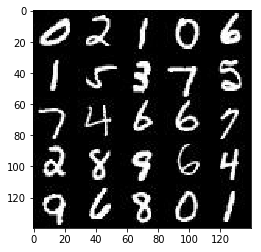

In [32]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
import pickle as pkl
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

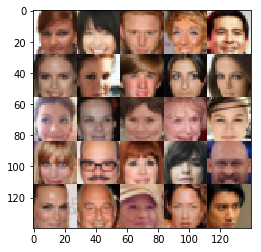

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [17]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    lrate = tf.placeholder(tf.float32, None, name='lrate')

    return inputs_real, inputs_z, lrate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [55]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    ksize = 5
    drop_rate = 0.9
    alpha = 0.2
    
    with tf.variable_scope('discriminator', reuse=reuse):
        
        x1 = tf.layers.conv2d(images, 64, ksize, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        #relu1 = tf.layers.dropout(relu1, rate=drop_rate)
        
        x2 = tf.layers.conv2d(relu1, 128, ksize, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * x2, x2)
        #relu2 = tf.layers.dropout(relu2, rate=drop_rate)
        
        x3 = tf.layers.conv2d(relu2, 256, ksize, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        #relu3 = tf.layers.dropout(relu3, rate=drop_rate)

        flat = tf.reshape(relu3, (-1,  4*4*256))
        logits = tf.layers.dense(flat, 1, activation=None)
        out = tf.sigmoid(logits)
        
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [56]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    ksize = 3
    alpha = 0.2
    keep_prob = 0.9
    reuse = not is_train
    
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 7x7x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 256, ksize, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        #x2 = tf.nn.dropout(x2, keep_prob=keep_prob)
        # 14x14x256 now
        
        x3 = tf.layers.conv2d_transpose(x2, 128, ksize, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        #x3 = tf.nn.dropout(x3, keep_prob=keep_prob)
        # 28x28x128 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, ksize, strides=1, padding='same')
        # 28x28x? now
        
        out = tf.tanh(logits)
        
        return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


#### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [52]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    
    smooth = 0.1
    
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_logits_real, 
            labels=tf.ones_like(d_model_real) * (1 - smooth)
        ))
    
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_logits_fake, 
            labels=tf.zeros_like(d_model_fake)
        ))
    
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_logits_fake, 
            labels=tf.ones_like(d_model_fake)
        ))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [53]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [46]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [47]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    
    print_every = 10
    show_every = 100
    n_images = 25

    samples, losses = [], []
    steps = 0
    
    _, image_width, image_height, image_channels = data_shape
    input_real, input_z, lrate = model_inputs(image_width, image_height, image_channels, z_dim)
    
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    saver = tf.train.Saver()
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # rescale
                batch_images *= 2
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i + 1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, n_images, input_z, image_channels, data_image_mode)
                    
                steps += 1

        saver.save(sess, './checkpoints/generator.ckpt')

    with open('samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    return losses, samples                

                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.7297... Generator Loss: 0.3195


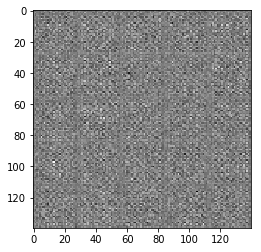

Epoch 1/2... Discriminator Loss: 0.6312... Generator Loss: 1.5435
Epoch 1/2... Discriminator Loss: 0.8702... Generator Loss: 1.0921
Epoch 1/2... Discriminator Loss: 1.5247... Generator Loss: 0.4464
Epoch 1/2... Discriminator Loss: 1.1059... Generator Loss: 1.1252
Epoch 1/2... Discriminator Loss: 1.4430... Generator Loss: 0.6339
Epoch 1/2... Discriminator Loss: 1.4173... Generator Loss: 0.6804
Epoch 1/2... Discriminator Loss: 1.4065... Generator Loss: 0.7276
Epoch 1/2... Discriminator Loss: 1.4660... Generator Loss: 0.5064
Epoch 1/2... Discriminator Loss: 1.4613... Generator Loss: 0.5748
Epoch 1/2... Discriminator Loss: 1.3740... Generator Loss: 0.6317


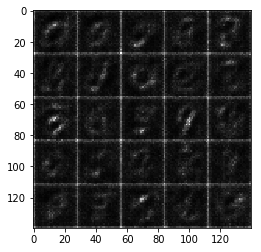

Epoch 1/2... Discriminator Loss: 1.3041... Generator Loss: 0.8555
Epoch 1/2... Discriminator Loss: 1.2459... Generator Loss: 0.8222
Epoch 1/2... Discriminator Loss: 1.3118... Generator Loss: 0.8523
Epoch 1/2... Discriminator Loss: 1.2821... Generator Loss: 1.0127
Epoch 1/2... Discriminator Loss: 1.1995... Generator Loss: 0.8862
Epoch 1/2... Discriminator Loss: 1.2158... Generator Loss: 0.9074
Epoch 1/2... Discriminator Loss: 1.3739... Generator Loss: 0.7126
Epoch 1/2... Discriminator Loss: 1.2790... Generator Loss: 0.5972
Epoch 1/2... Discriminator Loss: 1.1924... Generator Loss: 0.8863
Epoch 1/2... Discriminator Loss: 1.0896... Generator Loss: 0.8747


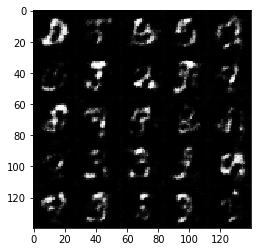

Epoch 1/2... Discriminator Loss: 1.1534... Generator Loss: 0.8029
Epoch 1/2... Discriminator Loss: 1.0210... Generator Loss: 1.2757
Epoch 1/2... Discriminator Loss: 1.0698... Generator Loss: 0.8618
Epoch 1/2... Discriminator Loss: 1.0720... Generator Loss: 1.3163
Epoch 1/2... Discriminator Loss: 1.0801... Generator Loss: 1.3574
Epoch 1/2... Discriminator Loss: 0.9433... Generator Loss: 1.0938
Epoch 1/2... Discriminator Loss: 1.0187... Generator Loss: 1.0587
Epoch 1/2... Discriminator Loss: 1.1271... Generator Loss: 0.8833
Epoch 1/2... Discriminator Loss: 1.0381... Generator Loss: 1.3449
Epoch 1/2... Discriminator Loss: 1.0681... Generator Loss: 0.8629


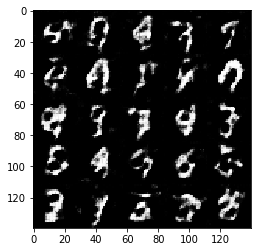

Epoch 1/2... Discriminator Loss: 1.0313... Generator Loss: 1.2681
Epoch 1/2... Discriminator Loss: 0.9475... Generator Loss: 1.2865
Epoch 1/2... Discriminator Loss: 1.2065... Generator Loss: 1.7834
Epoch 1/2... Discriminator Loss: 1.1582... Generator Loss: 0.8199
Epoch 1/2... Discriminator Loss: 1.0527... Generator Loss: 0.9969
Epoch 1/2... Discriminator Loss: 0.9980... Generator Loss: 0.9647
Epoch 1/2... Discriminator Loss: 1.4941... Generator Loss: 0.4306
Epoch 1/2... Discriminator Loss: 1.0895... Generator Loss: 0.9586
Epoch 1/2... Discriminator Loss: 1.0491... Generator Loss: 1.1831
Epoch 1/2... Discriminator Loss: 1.4987... Generator Loss: 0.4159


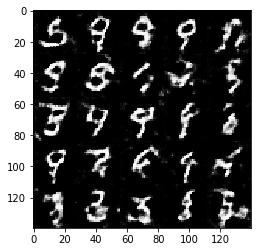

Epoch 1/2... Discriminator Loss: 1.2068... Generator Loss: 0.9297
Epoch 1/2... Discriminator Loss: 1.1841... Generator Loss: 0.7250
Epoch 1/2... Discriminator Loss: 1.3850... Generator Loss: 0.4965
Epoch 1/2... Discriminator Loss: 1.1938... Generator Loss: 0.6892
Epoch 1/2... Discriminator Loss: 1.3607... Generator Loss: 0.5287
Epoch 1/2... Discriminator Loss: 1.1561... Generator Loss: 1.5231
Epoch 1/2... Discriminator Loss: 1.0860... Generator Loss: 1.0258
Epoch 1/2... Discriminator Loss: 1.1683... Generator Loss: 1.2421
Epoch 1/2... Discriminator Loss: 1.2407... Generator Loss: 1.6295
Epoch 1/2... Discriminator Loss: 1.1771... Generator Loss: 0.7898


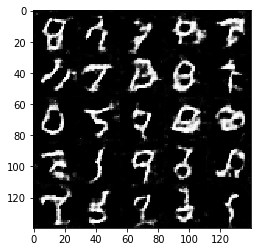

Epoch 1/2... Discriminator Loss: 1.0819... Generator Loss: 0.9908
Epoch 1/2... Discriminator Loss: 1.4242... Generator Loss: 0.4750
Epoch 1/2... Discriminator Loss: 1.1419... Generator Loss: 0.8849
Epoch 1/2... Discriminator Loss: 1.1762... Generator Loss: 1.1518
Epoch 1/2... Discriminator Loss: 1.1560... Generator Loss: 0.9409
Epoch 1/2... Discriminator Loss: 1.1841... Generator Loss: 1.2694
Epoch 1/2... Discriminator Loss: 1.2198... Generator Loss: 0.8339
Epoch 1/2... Discriminator Loss: 1.2984... Generator Loss: 1.5231
Epoch 1/2... Discriminator Loss: 1.0627... Generator Loss: 1.1061
Epoch 1/2... Discriminator Loss: 1.3223... Generator Loss: 0.5751


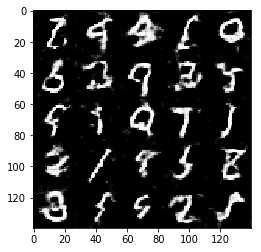

Epoch 1/2... Discriminator Loss: 1.2820... Generator Loss: 0.6394
Epoch 1/2... Discriminator Loss: 1.2367... Generator Loss: 0.8230
Epoch 1/2... Discriminator Loss: 1.0790... Generator Loss: 1.2186
Epoch 1/2... Discriminator Loss: 1.3049... Generator Loss: 0.7690
Epoch 1/2... Discriminator Loss: 1.1519... Generator Loss: 0.9213
Epoch 1/2... Discriminator Loss: 1.5850... Generator Loss: 0.3961
Epoch 1/2... Discriminator Loss: 1.0532... Generator Loss: 0.9637
Epoch 1/2... Discriminator Loss: 1.2205... Generator Loss: 0.7945
Epoch 1/2... Discriminator Loss: 1.2576... Generator Loss: 0.7901
Epoch 1/2... Discriminator Loss: 1.2564... Generator Loss: 0.6873


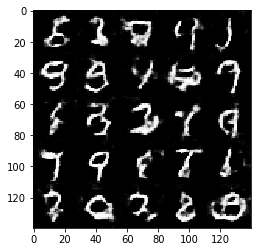

Epoch 1/2... Discriminator Loss: 1.1429... Generator Loss: 1.2923
Epoch 1/2... Discriminator Loss: 1.1988... Generator Loss: 0.6920
Epoch 1/2... Discriminator Loss: 1.3143... Generator Loss: 0.7244
Epoch 1/2... Discriminator Loss: 1.1286... Generator Loss: 0.8132
Epoch 1/2... Discriminator Loss: 1.1133... Generator Loss: 0.7909
Epoch 1/2... Discriminator Loss: 1.1150... Generator Loss: 0.9296
Epoch 1/2... Discriminator Loss: 1.1343... Generator Loss: 0.7966
Epoch 1/2... Discriminator Loss: 1.2085... Generator Loss: 0.9535
Epoch 1/2... Discriminator Loss: 1.1744... Generator Loss: 1.1547
Epoch 1/2... Discriminator Loss: 1.1768... Generator Loss: 0.7494


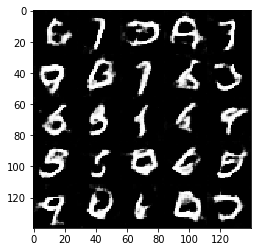

Epoch 1/2... Discriminator Loss: 1.0887... Generator Loss: 1.1777
Epoch 1/2... Discriminator Loss: 1.0937... Generator Loss: 0.9062
Epoch 1/2... Discriminator Loss: 1.1639... Generator Loss: 0.7865
Epoch 1/2... Discriminator Loss: 1.2224... Generator Loss: 1.4586
Epoch 1/2... Discriminator Loss: 1.1729... Generator Loss: 0.9682
Epoch 1/2... Discriminator Loss: 1.0535... Generator Loss: 1.1787
Epoch 1/2... Discriminator Loss: 1.0358... Generator Loss: 0.9940
Epoch 1/2... Discriminator Loss: 1.0946... Generator Loss: 0.9335
Epoch 1/2... Discriminator Loss: 1.2183... Generator Loss: 0.6644
Epoch 1/2... Discriminator Loss: 1.1089... Generator Loss: 1.0380


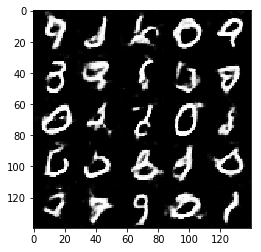

Epoch 1/2... Discriminator Loss: 1.1514... Generator Loss: 1.1698
Epoch 1/2... Discriminator Loss: 1.1612... Generator Loss: 0.7666
Epoch 1/2... Discriminator Loss: 1.0452... Generator Loss: 0.9584
Epoch 2/2... Discriminator Loss: 1.1614... Generator Loss: 0.6793
Epoch 2/2... Discriminator Loss: 1.0201... Generator Loss: 1.0740
Epoch 2/2... Discriminator Loss: 1.1075... Generator Loss: 0.8942
Epoch 2/2... Discriminator Loss: 1.1082... Generator Loss: 0.9206
Epoch 2/2... Discriminator Loss: 1.0915... Generator Loss: 0.9168
Epoch 2/2... Discriminator Loss: 1.0853... Generator Loss: 0.9125
Epoch 2/2... Discriminator Loss: 1.1146... Generator Loss: 0.9439


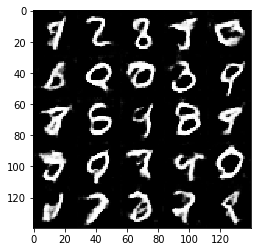

Epoch 2/2... Discriminator Loss: 1.1060... Generator Loss: 1.5337
Epoch 2/2... Discriminator Loss: 1.0726... Generator Loss: 0.9611
Epoch 2/2... Discriminator Loss: 1.2046... Generator Loss: 0.6770
Epoch 2/2... Discriminator Loss: 1.1032... Generator Loss: 0.8869
Epoch 2/2... Discriminator Loss: 1.0200... Generator Loss: 1.1149
Epoch 2/2... Discriminator Loss: 1.1119... Generator Loss: 0.7892
Epoch 2/2... Discriminator Loss: 1.2427... Generator Loss: 1.6381
Epoch 2/2... Discriminator Loss: 1.0427... Generator Loss: 1.3472
Epoch 2/2... Discriminator Loss: 1.0845... Generator Loss: 0.9563
Epoch 2/2... Discriminator Loss: 1.0616... Generator Loss: 1.1134


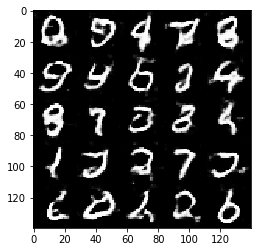

Epoch 2/2... Discriminator Loss: 1.0699... Generator Loss: 0.8755
Epoch 2/2... Discriminator Loss: 1.0532... Generator Loss: 1.0397
Epoch 2/2... Discriminator Loss: 1.0266... Generator Loss: 1.2819
Epoch 2/2... Discriminator Loss: 0.9536... Generator Loss: 1.1513
Epoch 2/2... Discriminator Loss: 1.1574... Generator Loss: 0.7911
Epoch 2/2... Discriminator Loss: 1.0597... Generator Loss: 0.9037
Epoch 2/2... Discriminator Loss: 1.0077... Generator Loss: 1.0933
Epoch 2/2... Discriminator Loss: 1.0748... Generator Loss: 1.3937
Epoch 2/2... Discriminator Loss: 0.9568... Generator Loss: 1.0252
Epoch 2/2... Discriminator Loss: 1.0065... Generator Loss: 1.6681


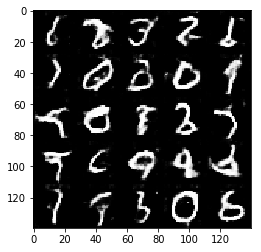

Epoch 2/2... Discriminator Loss: 1.0529... Generator Loss: 0.9187
Epoch 2/2... Discriminator Loss: 1.0637... Generator Loss: 1.3395
Epoch 2/2... Discriminator Loss: 0.9920... Generator Loss: 1.0335
Epoch 2/2... Discriminator Loss: 1.1604... Generator Loss: 0.8242
Epoch 2/2... Discriminator Loss: 1.0668... Generator Loss: 1.5157
Epoch 2/2... Discriminator Loss: 1.1760... Generator Loss: 0.7661
Epoch 2/2... Discriminator Loss: 1.0278... Generator Loss: 0.9885
Epoch 2/2... Discriminator Loss: 1.1678... Generator Loss: 1.1967
Epoch 2/2... Discriminator Loss: 1.1858... Generator Loss: 0.7275
Epoch 2/2... Discriminator Loss: 1.0582... Generator Loss: 1.1242


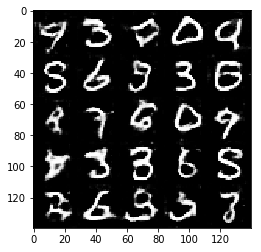

Epoch 2/2... Discriminator Loss: 1.0298... Generator Loss: 1.1651
Epoch 2/2... Discriminator Loss: 1.0467... Generator Loss: 1.3037
Epoch 2/2... Discriminator Loss: 0.9638... Generator Loss: 1.0038
Epoch 2/2... Discriminator Loss: 1.0868... Generator Loss: 1.0316
Epoch 2/2... Discriminator Loss: 1.0199... Generator Loss: 1.3542
Epoch 2/2... Discriminator Loss: 1.1570... Generator Loss: 0.7384
Epoch 2/2... Discriminator Loss: 1.0329... Generator Loss: 0.9979
Epoch 2/2... Discriminator Loss: 1.0906... Generator Loss: 0.8932
Epoch 2/2... Discriminator Loss: 1.1597... Generator Loss: 1.2283
Epoch 2/2... Discriminator Loss: 1.0238... Generator Loss: 1.0785


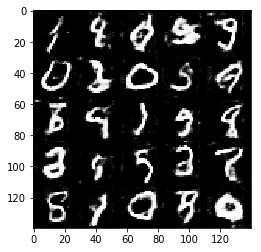

Epoch 2/2... Discriminator Loss: 1.0896... Generator Loss: 1.2741
Epoch 2/2... Discriminator Loss: 1.0724... Generator Loss: 1.0524
Epoch 2/2... Discriminator Loss: 1.0871... Generator Loss: 0.8865
Epoch 2/2... Discriminator Loss: 1.0647... Generator Loss: 1.3626
Epoch 2/2... Discriminator Loss: 1.2622... Generator Loss: 0.6269
Epoch 2/2... Discriminator Loss: 1.1620... Generator Loss: 1.5181
Epoch 2/2... Discriminator Loss: 1.2231... Generator Loss: 1.4341
Epoch 2/2... Discriminator Loss: 1.1399... Generator Loss: 0.9276
Epoch 2/2... Discriminator Loss: 1.1813... Generator Loss: 0.7807
Epoch 2/2... Discriminator Loss: 1.2287... Generator Loss: 0.6914


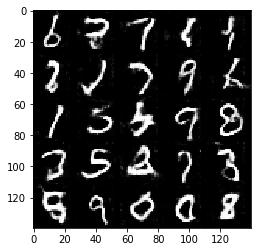

Epoch 2/2... Discriminator Loss: 1.1191... Generator Loss: 1.3355
Epoch 2/2... Discriminator Loss: 1.0833... Generator Loss: 1.2660
Epoch 2/2... Discriminator Loss: 1.0739... Generator Loss: 1.3638
Epoch 2/2... Discriminator Loss: 1.1979... Generator Loss: 0.7201
Epoch 2/2... Discriminator Loss: 1.0458... Generator Loss: 1.4273
Epoch 2/2... Discriminator Loss: 1.1551... Generator Loss: 1.0411
Epoch 2/2... Discriminator Loss: 1.1539... Generator Loss: 0.7607
Epoch 2/2... Discriminator Loss: 1.1639... Generator Loss: 0.7527
Epoch 2/2... Discriminator Loss: 1.1095... Generator Loss: 0.9837
Epoch 2/2... Discriminator Loss: 1.1160... Generator Loss: 0.9141


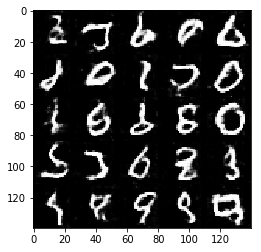

Epoch 2/2... Discriminator Loss: 1.1640... Generator Loss: 0.8728
Epoch 2/2... Discriminator Loss: 1.0339... Generator Loss: 1.2600
Epoch 2/2... Discriminator Loss: 1.3480... Generator Loss: 0.5522
Epoch 2/2... Discriminator Loss: 1.1769... Generator Loss: 0.7705
Epoch 2/2... Discriminator Loss: 1.2063... Generator Loss: 0.8379
Epoch 2/2... Discriminator Loss: 1.1175... Generator Loss: 1.3733
Epoch 2/2... Discriminator Loss: 1.1067... Generator Loss: 0.9807
Epoch 2/2... Discriminator Loss: 1.1948... Generator Loss: 1.4173
Epoch 2/2... Discriminator Loss: 1.1196... Generator Loss: 0.9129
Epoch 2/2... Discriminator Loss: 1.1807... Generator Loss: 0.9977


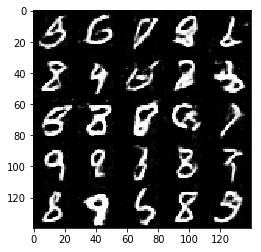

Epoch 2/2... Discriminator Loss: 1.1029... Generator Loss: 1.3024
Epoch 2/2... Discriminator Loss: 1.0430... Generator Loss: 1.4927
Epoch 2/2... Discriminator Loss: 1.0783... Generator Loss: 1.2719
Epoch 2/2... Discriminator Loss: 1.2156... Generator Loss: 0.8974
Epoch 2/2... Discriminator Loss: 0.9839... Generator Loss: 1.0921
Epoch 2/2... Discriminator Loss: 1.0941... Generator Loss: 0.9245
Epoch 2/2... Discriminator Loss: 1.1393... Generator Loss: 0.9756
Epoch 2/2... Discriminator Loss: 1.1128... Generator Loss: 0.8824
Epoch 2/2... Discriminator Loss: 1.0217... Generator Loss: 1.4634
Epoch 2/2... Discriminator Loss: 1.0526... Generator Loss: 1.0316


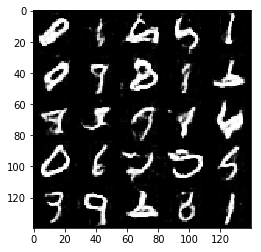

Epoch 2/2... Discriminator Loss: 1.2608... Generator Loss: 0.6566
Epoch 2/2... Discriminator Loss: 1.1565... Generator Loss: 0.7823
Epoch 2/2... Discriminator Loss: 1.1480... Generator Loss: 0.8493
Epoch 2/2... Discriminator Loss: 1.0828... Generator Loss: 1.2275
Epoch 2/2... Discriminator Loss: 1.0798... Generator Loss: 1.1571
Epoch 2/2... Discriminator Loss: 1.1424... Generator Loss: 1.2996
Epoch 2/2... Discriminator Loss: 1.0173... Generator Loss: 1.0282


In [40]:
batch_size = 64
z_dim = 128
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 2.1154... Generator Loss: 0.2290


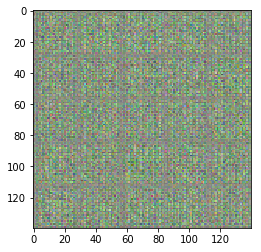

Epoch 1/1... Discriminator Loss: 0.3834... Generator Loss: 3.6470
Epoch 1/1... Discriminator Loss: 0.8125... Generator Loss: 1.3093
Epoch 1/1... Discriminator Loss: 0.4316... Generator Loss: 2.9484
Epoch 1/1... Discriminator Loss: 0.4490... Generator Loss: 3.0545
Epoch 1/1... Discriminator Loss: 0.3685... Generator Loss: 6.2552
Epoch 1/1... Discriminator Loss: 2.1854... Generator Loss: 0.3369
Epoch 1/1... Discriminator Loss: 0.4918... Generator Loss: 3.6301
Epoch 1/1... Discriminator Loss: 0.5147... Generator Loss: 4.5262
Epoch 1/1... Discriminator Loss: 1.1690... Generator Loss: 5.6561
Epoch 1/1... Discriminator Loss: 0.6172... Generator Loss: 2.8662


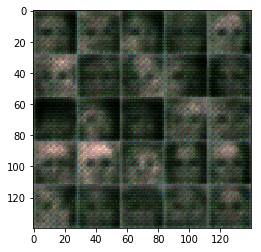

Epoch 1/1... Discriminator Loss: 0.4657... Generator Loss: 2.7054
Epoch 1/1... Discriminator Loss: 0.8255... Generator Loss: 1.2203
Epoch 1/1... Discriminator Loss: 0.7723... Generator Loss: 1.2242
Epoch 1/1... Discriminator Loss: 1.0042... Generator Loss: 0.8504
Epoch 1/1... Discriminator Loss: 0.5949... Generator Loss: 1.9182
Epoch 1/1... Discriminator Loss: 0.5503... Generator Loss: 1.9979
Epoch 1/1... Discriminator Loss: 0.5910... Generator Loss: 1.6272
Epoch 1/1... Discriminator Loss: 2.2036... Generator Loss: 6.9444
Epoch 1/1... Discriminator Loss: 0.5114... Generator Loss: 2.1335
Epoch 1/1... Discriminator Loss: 1.0992... Generator Loss: 0.9995


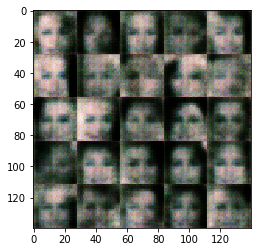

Epoch 1/1... Discriminator Loss: 0.7119... Generator Loss: 1.3883
Epoch 1/1... Discriminator Loss: 1.5548... Generator Loss: 0.4495
Epoch 1/1... Discriminator Loss: 1.0442... Generator Loss: 0.8137
Epoch 1/1... Discriminator Loss: 0.8774... Generator Loss: 1.5805
Epoch 1/1... Discriminator Loss: 0.7714... Generator Loss: 4.2423
Epoch 1/1... Discriminator Loss: 0.8540... Generator Loss: 1.9992
Epoch 1/1... Discriminator Loss: 1.3297... Generator Loss: 0.6149
Epoch 1/1... Discriminator Loss: 0.9890... Generator Loss: 0.8775
Epoch 1/1... Discriminator Loss: 1.3761... Generator Loss: 0.7123
Epoch 1/1... Discriminator Loss: 1.4220... Generator Loss: 10.5541


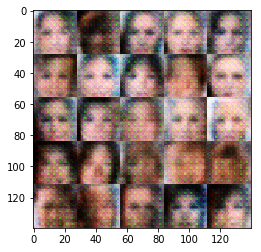

Epoch 1/1... Discriminator Loss: 0.6998... Generator Loss: 2.2643
Epoch 1/1... Discriminator Loss: 0.9876... Generator Loss: 6.2329
Epoch 1/1... Discriminator Loss: 0.8081... Generator Loss: 4.7093
Epoch 1/1... Discriminator Loss: 0.3997... Generator Loss: 3.2675
Epoch 1/1... Discriminator Loss: 0.4672... Generator Loss: 5.9941
Epoch 1/1... Discriminator Loss: 0.4869... Generator Loss: 3.8186
Epoch 1/1... Discriminator Loss: 1.2004... Generator Loss: 0.6578
Epoch 1/1... Discriminator Loss: 0.6526... Generator Loss: 3.9590
Epoch 1/1... Discriminator Loss: 0.5862... Generator Loss: 2.9756
Epoch 1/1... Discriminator Loss: 0.4424... Generator Loss: 3.1874


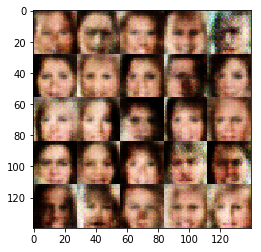

Epoch 1/1... Discriminator Loss: 0.8264... Generator Loss: 1.6493
Epoch 1/1... Discriminator Loss: 0.3732... Generator Loss: 7.5761
Epoch 1/1... Discriminator Loss: 0.9097... Generator Loss: 2.0319
Epoch 1/1... Discriminator Loss: 0.9792... Generator Loss: 1.0783
Epoch 1/1... Discriminator Loss: 0.8041... Generator Loss: 1.1149
Epoch 1/1... Discriminator Loss: 0.8121... Generator Loss: 1.3517
Epoch 1/1... Discriminator Loss: 0.5437... Generator Loss: 3.4420
Epoch 1/1... Discriminator Loss: 1.2470... Generator Loss: 0.5925
Epoch 1/1... Discriminator Loss: 0.8196... Generator Loss: 1.3102
Epoch 1/1... Discriminator Loss: 0.6878... Generator Loss: 1.9873


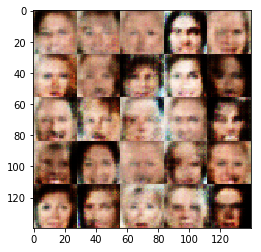

Epoch 1/1... Discriminator Loss: 0.9062... Generator Loss: 1.0615
Epoch 1/1... Discriminator Loss: 0.8277... Generator Loss: 1.5177
Epoch 1/1... Discriminator Loss: 0.6508... Generator Loss: 1.7989
Epoch 1/1... Discriminator Loss: 0.6154... Generator Loss: 1.6749
Epoch 1/1... Discriminator Loss: 0.6454... Generator Loss: 1.6197
Epoch 1/1... Discriminator Loss: 0.6021... Generator Loss: 2.1620
Epoch 1/1... Discriminator Loss: 1.1156... Generator Loss: 0.7436
Epoch 1/1... Discriminator Loss: 0.7230... Generator Loss: 1.2460
Epoch 1/1... Discriminator Loss: 0.8899... Generator Loss: 2.5150
Epoch 1/1... Discriminator Loss: 0.5887... Generator Loss: 2.3971


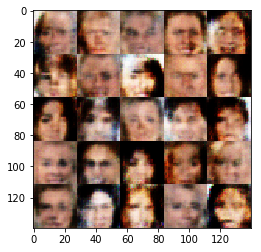

Epoch 1/1... Discriminator Loss: 0.5162... Generator Loss: 3.9339
Epoch 1/1... Discriminator Loss: 0.9635... Generator Loss: 5.4938
Epoch 1/1... Discriminator Loss: 0.8897... Generator Loss: 4.0291
Epoch 1/1... Discriminator Loss: 0.4697... Generator Loss: 4.2766
Epoch 1/1... Discriminator Loss: 0.5364... Generator Loss: 3.4560
Epoch 1/1... Discriminator Loss: 0.6540... Generator Loss: 2.6762
Epoch 1/1... Discriminator Loss: 0.5168... Generator Loss: 6.0222
Epoch 1/1... Discriminator Loss: 0.4549... Generator Loss: 3.8004
Epoch 1/1... Discriminator Loss: 0.4150... Generator Loss: 4.2879
Epoch 1/1... Discriminator Loss: 0.7146... Generator Loss: 3.4615


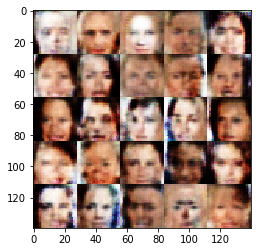

Epoch 1/1... Discriminator Loss: 0.4728... Generator Loss: 4.7934
Epoch 1/1... Discriminator Loss: 0.3747... Generator Loss: 4.0944
Epoch 1/1... Discriminator Loss: 0.5166... Generator Loss: 4.0416
Epoch 1/1... Discriminator Loss: 0.5679... Generator Loss: 4.9652
Epoch 1/1... Discriminator Loss: 0.4257... Generator Loss: 3.6229
Epoch 1/1... Discriminator Loss: 0.5338... Generator Loss: 1.9818
Epoch 1/1... Discriminator Loss: 0.5522... Generator Loss: 4.1109
Epoch 1/1... Discriminator Loss: 0.4356... Generator Loss: 2.9042
Epoch 1/1... Discriminator Loss: 0.4628... Generator Loss: 3.7718
Epoch 1/1... Discriminator Loss: 0.7176... Generator Loss: 4.2059


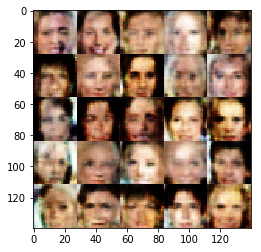

Epoch 1/1... Discriminator Loss: 0.5422... Generator Loss: 2.0925
Epoch 1/1... Discriminator Loss: 0.7494... Generator Loss: 2.7858
Epoch 1/1... Discriminator Loss: 0.5184... Generator Loss: 2.9477
Epoch 1/1... Discriminator Loss: 0.6157... Generator Loss: 2.9389
Epoch 1/1... Discriminator Loss: 0.5014... Generator Loss: 4.3016
Epoch 1/1... Discriminator Loss: 0.4373... Generator Loss: 3.7662
Epoch 1/1... Discriminator Loss: 0.9658... Generator Loss: 0.9120
Epoch 1/1... Discriminator Loss: 0.4759... Generator Loss: 3.0533
Epoch 1/1... Discriminator Loss: 0.6117... Generator Loss: 2.1425
Epoch 1/1... Discriminator Loss: 0.4259... Generator Loss: 4.5659


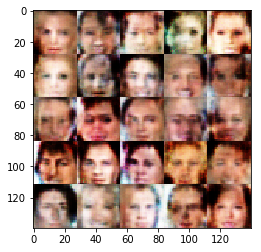

Epoch 1/1... Discriminator Loss: 0.6423... Generator Loss: 3.4972
Epoch 1/1... Discriminator Loss: 0.4896... Generator Loss: 3.5198
Epoch 1/1... Discriminator Loss: 0.4577... Generator Loss: 3.1671
Epoch 1/1... Discriminator Loss: 0.6033... Generator Loss: 3.4418
Epoch 1/1... Discriminator Loss: 0.4687... Generator Loss: 3.5382
Epoch 1/1... Discriminator Loss: 0.4574... Generator Loss: 2.6173
Epoch 1/1... Discriminator Loss: 0.4947... Generator Loss: 2.7870
Epoch 1/1... Discriminator Loss: 0.4351... Generator Loss: 3.4941
Epoch 1/1... Discriminator Loss: 0.5146... Generator Loss: 2.8317
Epoch 1/1... Discriminator Loss: 0.4770... Generator Loss: 3.6274


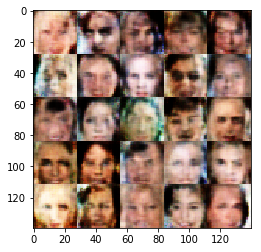

Epoch 1/1... Discriminator Loss: 0.8063... Generator Loss: 1.9210
Epoch 1/1... Discriminator Loss: 0.8297... Generator Loss: 1.1222
Epoch 1/1... Discriminator Loss: 0.4897... Generator Loss: 3.8363
Epoch 1/1... Discriminator Loss: 0.4766... Generator Loss: 3.7274
Epoch 1/1... Discriminator Loss: 0.7887... Generator Loss: 4.7535
Epoch 1/1... Discriminator Loss: 1.0083... Generator Loss: 0.9455
Epoch 1/1... Discriminator Loss: 0.4443... Generator Loss: 4.1957
Epoch 1/1... Discriminator Loss: 0.8337... Generator Loss: 1.2006
Epoch 1/1... Discriminator Loss: 0.4429... Generator Loss: 2.9847
Epoch 1/1... Discriminator Loss: 0.8796... Generator Loss: 0.9933


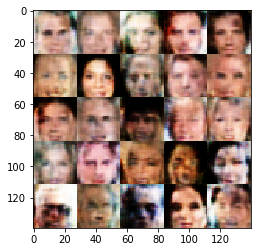

Epoch 1/1... Discriminator Loss: 0.7718... Generator Loss: 4.1052
Epoch 1/1... Discriminator Loss: 0.4836... Generator Loss: 2.7996
Epoch 1/1... Discriminator Loss: 0.5075... Generator Loss: 4.6950
Epoch 1/1... Discriminator Loss: 0.5152... Generator Loss: 5.0205
Epoch 1/1... Discriminator Loss: 0.9488... Generator Loss: 3.6279
Epoch 1/1... Discriminator Loss: 0.6121... Generator Loss: 2.2516
Epoch 1/1... Discriminator Loss: 0.6508... Generator Loss: 1.5856
Epoch 1/1... Discriminator Loss: 0.4138... Generator Loss: 3.4777
Epoch 1/1... Discriminator Loss: 0.5937... Generator Loss: 4.1605
Epoch 1/1... Discriminator Loss: 0.6727... Generator Loss: 1.6634


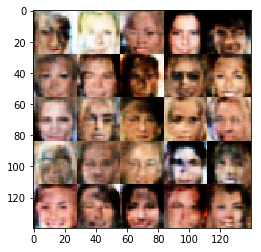

Epoch 1/1... Discriminator Loss: 0.4834... Generator Loss: 3.1252
Epoch 1/1... Discriminator Loss: 1.1503... Generator Loss: 4.2871
Epoch 1/1... Discriminator Loss: 0.4192... Generator Loss: 6.4745
Epoch 1/1... Discriminator Loss: 0.5643... Generator Loss: 2.1527
Epoch 1/1... Discriminator Loss: 0.5275... Generator Loss: 2.7437
Epoch 1/1... Discriminator Loss: 0.5888... Generator Loss: 1.8260
Epoch 1/1... Discriminator Loss: 0.4085... Generator Loss: 4.2629
Epoch 1/1... Discriminator Loss: 0.5869... Generator Loss: 1.7986
Epoch 1/1... Discriminator Loss: 0.6337... Generator Loss: 4.4941
Epoch 1/1... Discriminator Loss: 0.5000... Generator Loss: 3.0223


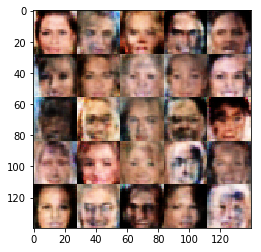

Epoch 1/1... Discriminator Loss: 0.8540... Generator Loss: 4.6350
Epoch 1/1... Discriminator Loss: 0.4861... Generator Loss: 3.4628
Epoch 1/1... Discriminator Loss: 0.3552... Generator Loss: 5.2091
Epoch 1/1... Discriminator Loss: 0.5709... Generator Loss: 2.4629
Epoch 1/1... Discriminator Loss: 0.5277... Generator Loss: 2.9799
Epoch 1/1... Discriminator Loss: 0.6046... Generator Loss: 1.6364
Epoch 1/1... Discriminator Loss: 0.4625... Generator Loss: 3.4598
Epoch 1/1... Discriminator Loss: 0.4067... Generator Loss: 4.0124
Epoch 1/1... Discriminator Loss: 0.6913... Generator Loss: 3.1101
Epoch 1/1... Discriminator Loss: 0.7656... Generator Loss: 1.9347


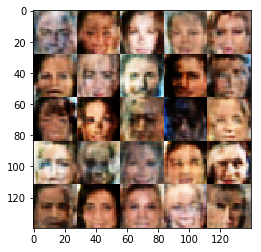

Epoch 1/1... Discriminator Loss: 0.7617... Generator Loss: 3.9088
Epoch 1/1... Discriminator Loss: 0.4190... Generator Loss: 3.5171
Epoch 1/1... Discriminator Loss: 1.2573... Generator Loss: 0.6025
Epoch 1/1... Discriminator Loss: 0.5462... Generator Loss: 3.4721
Epoch 1/1... Discriminator Loss: 0.6831... Generator Loss: 2.5651
Epoch 1/1... Discriminator Loss: 0.9359... Generator Loss: 2.4692
Epoch 1/1... Discriminator Loss: 0.4601... Generator Loss: 2.7368
Epoch 1/1... Discriminator Loss: 1.0243... Generator Loss: 0.8060
Epoch 1/1... Discriminator Loss: 0.7507... Generator Loss: 1.5603
Epoch 1/1... Discriminator Loss: 0.6126... Generator Loss: 1.8463


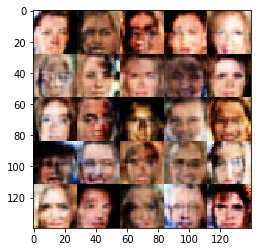

Epoch 1/1... Discriminator Loss: 0.4775... Generator Loss: 3.0137
Epoch 1/1... Discriminator Loss: 0.5681... Generator Loss: 3.9013
Epoch 1/1... Discriminator Loss: 0.5297... Generator Loss: 2.9499
Epoch 1/1... Discriminator Loss: 0.7466... Generator Loss: 1.9218
Epoch 1/1... Discriminator Loss: 0.6978... Generator Loss: 1.9482
Epoch 1/1... Discriminator Loss: 0.8816... Generator Loss: 3.9237
Epoch 1/1... Discriminator Loss: 0.5846... Generator Loss: 3.1864
Epoch 1/1... Discriminator Loss: 0.4871... Generator Loss: 3.3176
Epoch 1/1... Discriminator Loss: 0.4237... Generator Loss: 3.3436
Epoch 1/1... Discriminator Loss: 0.5943... Generator Loss: 3.2660


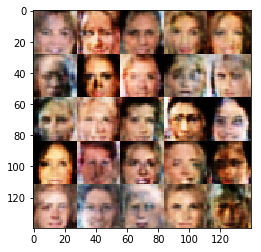

Epoch 1/1... Discriminator Loss: 0.5570... Generator Loss: 2.3481
Epoch 1/1... Discriminator Loss: 0.9629... Generator Loss: 1.8161
Epoch 1/1... Discriminator Loss: 0.7616... Generator Loss: 1.4968
Epoch 1/1... Discriminator Loss: 0.7597... Generator Loss: 2.0114
Epoch 1/1... Discriminator Loss: 0.5639... Generator Loss: 2.0978
Epoch 1/1... Discriminator Loss: 0.7865... Generator Loss: 1.4760
Epoch 1/1... Discriminator Loss: 0.5815... Generator Loss: 4.2235
Epoch 1/1... Discriminator Loss: 0.6845... Generator Loss: 1.4578
Epoch 1/1... Discriminator Loss: 0.6540... Generator Loss: 1.7427
Epoch 1/1... Discriminator Loss: 0.8070... Generator Loss: 1.8460


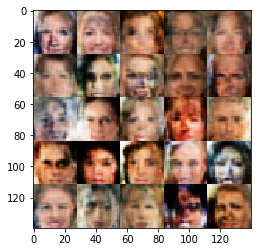

Epoch 1/1... Discriminator Loss: 0.4559... Generator Loss: 2.7951
Epoch 1/1... Discriminator Loss: 0.6681... Generator Loss: 2.7349
Epoch 1/1... Discriminator Loss: 0.5661... Generator Loss: 2.5307
Epoch 1/1... Discriminator Loss: 0.5120... Generator Loss: 2.3315
Epoch 1/1... Discriminator Loss: 0.8830... Generator Loss: 1.1981
Epoch 1/1... Discriminator Loss: 0.7388... Generator Loss: 1.9142
Epoch 1/1... Discriminator Loss: 0.9181... Generator Loss: 1.3988
Epoch 1/1... Discriminator Loss: 0.9012... Generator Loss: 1.0560
Epoch 1/1... Discriminator Loss: 0.6933... Generator Loss: 1.5703
Epoch 1/1... Discriminator Loss: 0.6987... Generator Loss: 2.2138


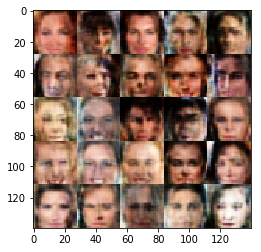

Epoch 1/1... Discriminator Loss: 0.4389... Generator Loss: 3.4653
Epoch 1/1... Discriminator Loss: 0.6567... Generator Loss: 1.7878
Epoch 1/1... Discriminator Loss: 0.6939... Generator Loss: 2.4647
Epoch 1/1... Discriminator Loss: 0.6607... Generator Loss: 2.1131
Epoch 1/1... Discriminator Loss: 0.5669... Generator Loss: 2.9306
Epoch 1/1... Discriminator Loss: 0.6699... Generator Loss: 1.5843
Epoch 1/1... Discriminator Loss: 0.4794... Generator Loss: 3.4771
Epoch 1/1... Discriminator Loss: 0.8963... Generator Loss: 1.4524
Epoch 1/1... Discriminator Loss: 0.5472... Generator Loss: 3.5788
Epoch 1/1... Discriminator Loss: 0.4776... Generator Loss: 6.1328


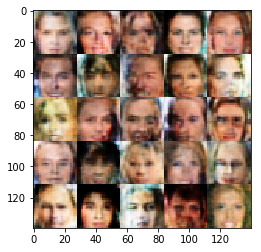

Epoch 1/1... Discriminator Loss: 0.3673... Generator Loss: 4.6802
Epoch 1/1... Discriminator Loss: 0.4728... Generator Loss: 2.5476
Epoch 1/1... Discriminator Loss: 0.4208... Generator Loss: 3.0441
Epoch 1/1... Discriminator Loss: 0.5639... Generator Loss: 2.3520
Epoch 1/1... Discriminator Loss: 1.3015... Generator Loss: 0.5719
Epoch 1/1... Discriminator Loss: 0.6384... Generator Loss: 1.9524
Epoch 1/1... Discriminator Loss: 0.6962... Generator Loss: 2.5520
Epoch 1/1... Discriminator Loss: 0.6041... Generator Loss: 3.7595
Epoch 1/1... Discriminator Loss: 0.9929... Generator Loss: 1.7645
Epoch 1/1... Discriminator Loss: 0.7777... Generator Loss: 1.6992


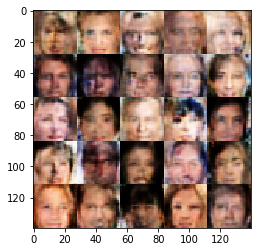

Epoch 1/1... Discriminator Loss: 0.9037... Generator Loss: 1.0979
Epoch 1/1... Discriminator Loss: 0.7773... Generator Loss: 1.3601
Epoch 1/1... Discriminator Loss: 1.0777... Generator Loss: 2.3867
Epoch 1/1... Discriminator Loss: 0.8154... Generator Loss: 1.3252
Epoch 1/1... Discriminator Loss: 0.6301... Generator Loss: 3.2203
Epoch 1/1... Discriminator Loss: 0.6205... Generator Loss: 1.8539
Epoch 1/1... Discriminator Loss: 0.4702... Generator Loss: 3.0229
Epoch 1/1... Discriminator Loss: 0.6909... Generator Loss: 2.0644
Epoch 1/1... Discriminator Loss: 0.6409... Generator Loss: 2.5930
Epoch 1/1... Discriminator Loss: 0.6365... Generator Loss: 1.6487


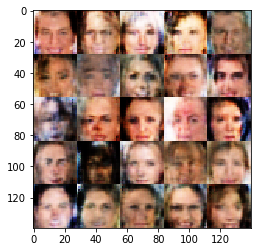

Epoch 1/1... Discriminator Loss: 0.7096... Generator Loss: 1.8831
Epoch 1/1... Discriminator Loss: 0.7438... Generator Loss: 1.4232
Epoch 1/1... Discriminator Loss: 0.5688... Generator Loss: 3.5433
Epoch 1/1... Discriminator Loss: 0.6066... Generator Loss: 2.4952
Epoch 1/1... Discriminator Loss: 0.9316... Generator Loss: 1.0191
Epoch 1/1... Discriminator Loss: 0.7297... Generator Loss: 2.6557
Epoch 1/1... Discriminator Loss: 0.8040... Generator Loss: 1.3388
Epoch 1/1... Discriminator Loss: 0.3795... Generator Loss: 5.3869
Epoch 1/1... Discriminator Loss: 0.6357... Generator Loss: 1.7785
Epoch 1/1... Discriminator Loss: 0.6858... Generator Loss: 2.2047


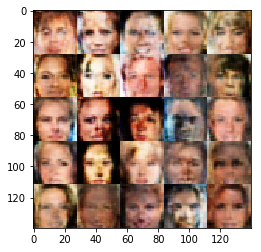

Epoch 1/1... Discriminator Loss: 0.9114... Generator Loss: 3.0009
Epoch 1/1... Discriminator Loss: 0.8387... Generator Loss: 1.2699
Epoch 1/1... Discriminator Loss: 0.9550... Generator Loss: 0.9696
Epoch 1/1... Discriminator Loss: 0.9921... Generator Loss: 1.9549
Epoch 1/1... Discriminator Loss: 0.8308... Generator Loss: 1.2871
Epoch 1/1... Discriminator Loss: 0.5210... Generator Loss: 2.5038
Epoch 1/1... Discriminator Loss: 0.7043... Generator Loss: 1.6695
Epoch 1/1... Discriminator Loss: 0.6375... Generator Loss: 2.0523
Epoch 1/1... Discriminator Loss: 0.5412... Generator Loss: 2.2529
Epoch 1/1... Discriminator Loss: 0.6561... Generator Loss: 1.7064


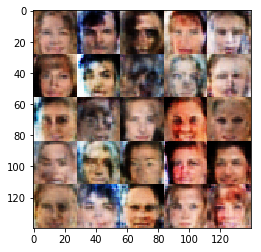

Epoch 1/1... Discriminator Loss: 0.7608... Generator Loss: 1.3124
Epoch 1/1... Discriminator Loss: 0.5579... Generator Loss: 2.4738
Epoch 1/1... Discriminator Loss: 1.1348... Generator Loss: 0.7721
Epoch 1/1... Discriminator Loss: 0.7328... Generator Loss: 1.4270
Epoch 1/1... Discriminator Loss: 1.2625... Generator Loss: 0.6026
Epoch 1/1... Discriminator Loss: 0.7988... Generator Loss: 1.4430
Epoch 1/1... Discriminator Loss: 0.6675... Generator Loss: 2.0740
Epoch 1/1... Discriminator Loss: 0.9300... Generator Loss: 1.0593
Epoch 1/1... Discriminator Loss: 0.4195... Generator Loss: 3.5382
Epoch 1/1... Discriminator Loss: 0.7305... Generator Loss: 1.5778


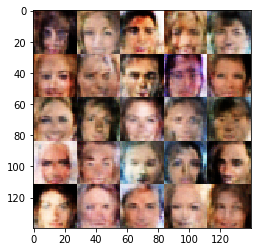

Epoch 1/1... Discriminator Loss: 0.7401... Generator Loss: 3.5543
Epoch 1/1... Discriminator Loss: 0.5750... Generator Loss: 2.0933
Epoch 1/1... Discriminator Loss: 0.4654... Generator Loss: 3.8422
Epoch 1/1... Discriminator Loss: 0.8623... Generator Loss: 4.9812
Epoch 1/1... Discriminator Loss: 0.5791... Generator Loss: 2.6483
Epoch 1/1... Discriminator Loss: 1.2024... Generator Loss: 0.6734
Epoch 1/1... Discriminator Loss: 0.6233... Generator Loss: 2.1113
Epoch 1/1... Discriminator Loss: 0.6621... Generator Loss: 2.8948
Epoch 1/1... Discriminator Loss: 0.8708... Generator Loss: 3.6834
Epoch 1/1... Discriminator Loss: 0.5478... Generator Loss: 3.1197


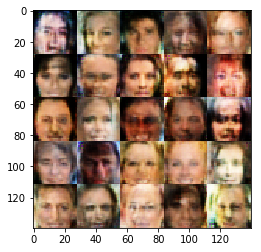

Epoch 1/1... Discriminator Loss: 0.5892... Generator Loss: 2.4517
Epoch 1/1... Discriminator Loss: 0.5890... Generator Loss: 1.8867
Epoch 1/1... Discriminator Loss: 0.4467... Generator Loss: 3.2534
Epoch 1/1... Discriminator Loss: 0.5116... Generator Loss: 2.3265
Epoch 1/1... Discriminator Loss: 0.3571... Generator Loss: 7.4037
Epoch 1/1... Discriminator Loss: 0.6739... Generator Loss: 2.2515
Epoch 1/1... Discriminator Loss: 0.5288... Generator Loss: 3.9350
Epoch 1/1... Discriminator Loss: 0.9612... Generator Loss: 1.9896
Epoch 1/1... Discriminator Loss: 0.7071... Generator Loss: 1.5444
Epoch 1/1... Discriminator Loss: 0.7735... Generator Loss: 2.0785


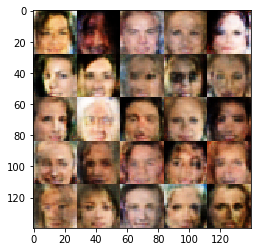

Epoch 1/1... Discriminator Loss: 0.4204... Generator Loss: 4.1093
Epoch 1/1... Discriminator Loss: 0.6414... Generator Loss: 2.2257
Epoch 1/1... Discriminator Loss: 0.6784... Generator Loss: 2.4070
Epoch 1/1... Discriminator Loss: 0.8003... Generator Loss: 1.2880
Epoch 1/1... Discriminator Loss: 0.9800... Generator Loss: 1.0391
Epoch 1/1... Discriminator Loss: 0.8680... Generator Loss: 1.1108
Epoch 1/1... Discriminator Loss: 0.6417... Generator Loss: 2.1438
Epoch 1/1... Discriminator Loss: 0.4537... Generator Loss: 4.4114
Epoch 1/1... Discriminator Loss: 0.4241... Generator Loss: 3.1880
Epoch 1/1... Discriminator Loss: 0.6628... Generator Loss: 1.6720


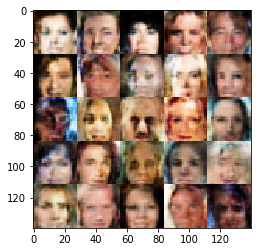

Epoch 1/1... Discriminator Loss: 0.6196... Generator Loss: 1.7862
Epoch 1/1... Discriminator Loss: 0.4920... Generator Loss: 2.6619
Epoch 1/1... Discriminator Loss: 0.6508... Generator Loss: 4.9974
Epoch 1/1... Discriminator Loss: 0.4087... Generator Loss: 3.9788
Epoch 1/1... Discriminator Loss: 0.6568... Generator Loss: 1.7544
Epoch 1/1... Discriminator Loss: 0.4804... Generator Loss: 2.9354
Epoch 1/1... Discriminator Loss: 0.4312... Generator Loss: 3.5366
Epoch 1/1... Discriminator Loss: 0.4595... Generator Loss: 3.0554
Epoch 1/1... Discriminator Loss: 0.7119... Generator Loss: 1.3871
Epoch 1/1... Discriminator Loss: 0.4271... Generator Loss: 3.9246


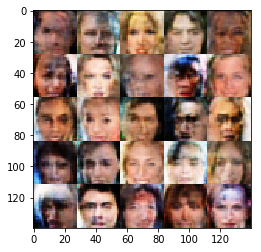

Epoch 1/1... Discriminator Loss: 0.4383... Generator Loss: 4.8551
Epoch 1/1... Discriminator Loss: 0.3791... Generator Loss: 5.1209
Epoch 1/1... Discriminator Loss: 0.5352... Generator Loss: 5.3332
Epoch 1/1... Discriminator Loss: 0.3964... Generator Loss: 3.8246
Epoch 1/1... Discriminator Loss: 0.5020... Generator Loss: 5.5266
Epoch 1/1... Discriminator Loss: 0.4649... Generator Loss: 4.6389
Epoch 1/1... Discriminator Loss: 0.6783... Generator Loss: 1.9518
Epoch 1/1... Discriminator Loss: 0.7200... Generator Loss: 2.2087
Epoch 1/1... Discriminator Loss: 0.5733... Generator Loss: 2.1809
Epoch 1/1... Discriminator Loss: 0.7629... Generator Loss: 2.0712


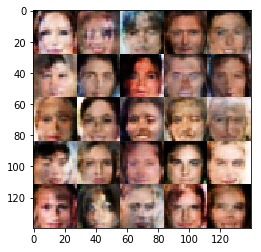

Epoch 1/1... Discriminator Loss: 0.4497... Generator Loss: 3.1011
Epoch 1/1... Discriminator Loss: 0.7592... Generator Loss: 1.5890
Epoch 1/1... Discriminator Loss: 0.5707... Generator Loss: 2.4653
Epoch 1/1... Discriminator Loss: 0.7700... Generator Loss: 1.3985
Epoch 1/1... Discriminator Loss: 0.5930... Generator Loss: 2.2691
Epoch 1/1... Discriminator Loss: 0.6298... Generator Loss: 1.7229
Epoch 1/1... Discriminator Loss: 0.7705... Generator Loss: 1.8140
Epoch 1/1... Discriminator Loss: 0.3846... Generator Loss: 4.9350
Epoch 1/1... Discriminator Loss: 0.4608... Generator Loss: 3.8766
Epoch 1/1... Discriminator Loss: 0.5839... Generator Loss: 2.0490


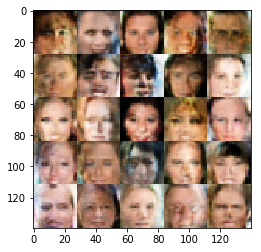

Epoch 1/1... Discriminator Loss: 0.9955... Generator Loss: 1.1741
Epoch 1/1... Discriminator Loss: 0.9726... Generator Loss: 0.9523
Epoch 1/1... Discriminator Loss: 0.7946... Generator Loss: 1.2499
Epoch 1/1... Discriminator Loss: 0.5851... Generator Loss: 2.0709
Epoch 1/1... Discriminator Loss: 0.6129... Generator Loss: 2.4189
Epoch 1/1... Discriminator Loss: 0.5472... Generator Loss: 2.4199
Epoch 1/1... Discriminator Loss: 0.5692... Generator Loss: 2.8982
Epoch 1/1... Discriminator Loss: 0.4346... Generator Loss: 4.3614
Epoch 1/1... Discriminator Loss: 0.7832... Generator Loss: 1.6513
Epoch 1/1... Discriminator Loss: 0.7413... Generator Loss: 1.4926


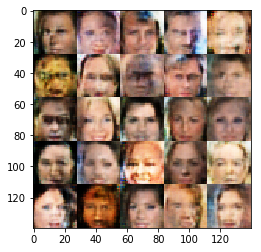

Epoch 1/1... Discriminator Loss: 0.5185... Generator Loss: 2.5712
Epoch 1/1... Discriminator Loss: 0.5608... Generator Loss: 2.4948
Epoch 1/1... Discriminator Loss: 0.4724... Generator Loss: 4.7739
Epoch 1/1... Discriminator Loss: 0.4084... Generator Loss: 4.3497
Epoch 1/1... Discriminator Loss: 0.5308... Generator Loss: 2.2191
Epoch 1/1... Discriminator Loss: 0.6809... Generator Loss: 1.7542


In [57]:
batch_size = 64
z_dim = 128
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.